# Vector Autoregressive Methods
Maria Eloisa Ventura | 2020 November 20

## Multivariate Time Series

In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
from statsmodels.tsa.vector_ar.var_model import VAR, FEVD
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss, coint
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import mvts_utils as utils
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4zc85l7w because the default path (/home/mventura/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Load  data

#### Air Quality Data from UCI

The dataset contains hourly averaged measurements obtained from an Air Quality Chemical Multisensor Device which was located on the field of polluted area at an Italian city. The dataset can be downloaded __[here](https://archive.ics.uci.edu/ml/datasets/Air+Quality#)__.

In [2]:
aq_df = pd.read_excel("data/AirQualityUCI/AirQualityUCI.xlsx", parse_dates=[['Date', 'Time']])\
            .set_index('Date_Time').replace(-200, np.nan).interpolate()
aq_df.head(1)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.881723,1045.5,166.0,1056.25,113.0,1692.0,1267.5,13.6,48.875001,0.757754


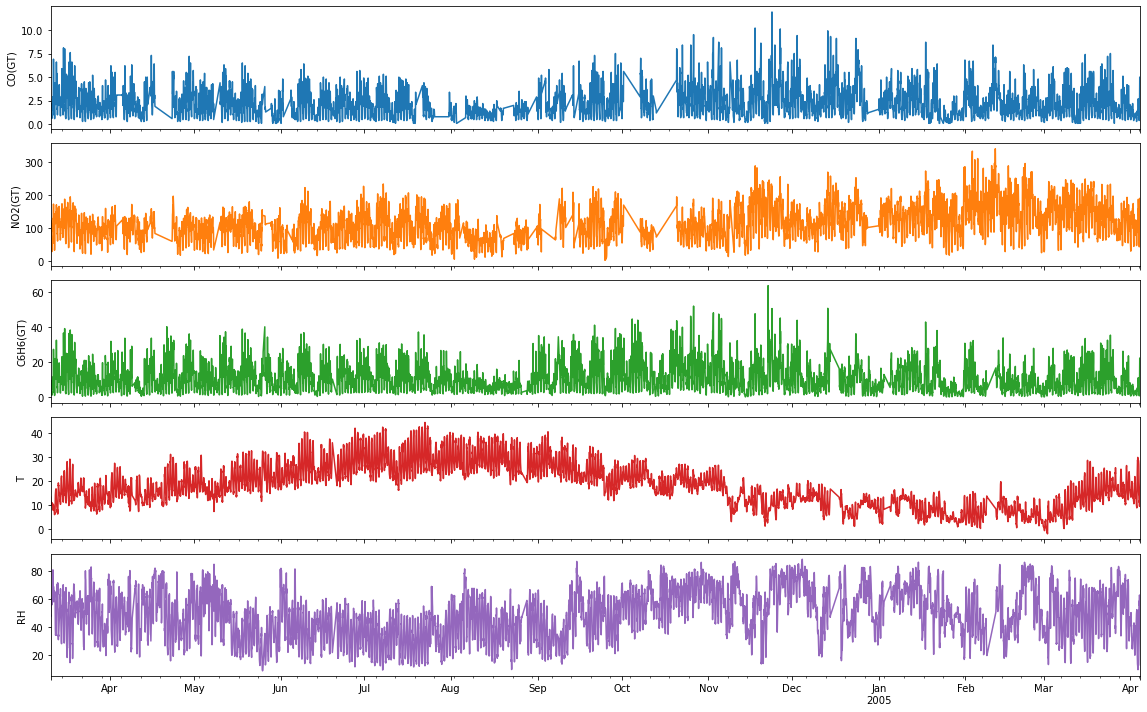

In [3]:
fig,ax = plt.subplots(5, figsize=(16,10), sharex=True)
plot_cols = ['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH']
aq_df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

#### Global Health from The World Bank

This dataset combines key health statistics from a variety of sources to provide a look at global health and population trends. It includes information on nutrition, reproductive health, education, immunization, and diseases from over 200 countries. The dataset can be downloaded __[here](https://console.cloud.google.com/marketplace/product/the-world-bank/global-health?filter=solution-type:dataset&filter=category:health&id=f3c38e10-2c45-43c8-8a12-8d749ba987ee)__.

In [4]:
ind_df = pd.read_csv('data/WorldBankHealth/WorldBankHealthPopulation_SeriesSummary.csv')\
            .loc[:,['series_code', 'indicator_name']].drop_duplicates().reindex()\
            .sort_values('indicator_name').set_index('series_code')
hn_df = pd.read_csv('data/WorldBankHealth/WorldBankHealthPopulation_HealthNutritionPopulation.csv')\
            .pivot(index='year', columns='indicator_code', values='value')

cols = ['SH.XPD.KHEX.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SH.XPD.GHED.GD.ZS']
health_expenditure_df = hn_df.loc[np.arange(2000, 2018), cols]\
    .rename(columns = dict(ind_df.loc[cols].indicator_name\
                           .apply(lambda x: '_'.join(x.split('(')[0].split(' ')[:-1]))))
health_expenditure_df.index = pd.date_range('2000-1-1', periods=len(health_expenditure_df), freq="A-DEC")
health_expenditure_df.head(2)

indicator_code,Capital_health_expenditure,Current_health_expenditure,Domestic_general_government_health_expenditure
2000-12-31,0.013654,3.154818,1.400685
2001-12-31,0.012675,2.947059,1.196554


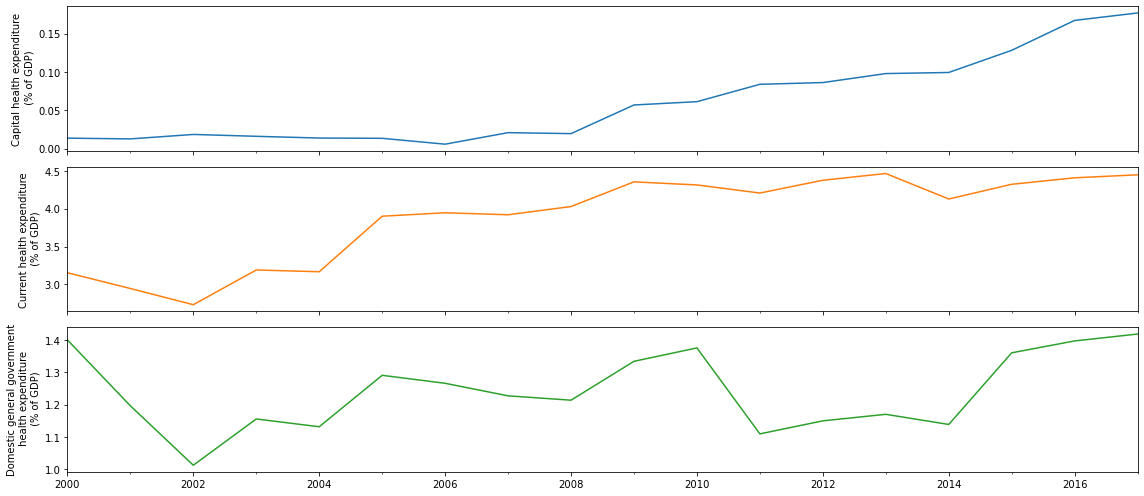

In [5]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 7))
health_expenditure_df.plot(subplots=True, ax=ax, legend=False)
y_label = ['Capital health expenditure', 'Current health expenditure',
           'Domestic general government\n health expenditure']
for a in range(len(ax)): 
    ax[a].set_ylabel(f"{y_label[a]}\n (% of GDP)")
plt.tight_layout()
plt.show()

#### US Treasury Rates
January, 1982 – December, 2016  (Weekly)
https://essentialoftimeseries.com/data/
This sample dataset contains weekly data of US Treasury rates from January 1982 to December 2016. The dataset can be downloaded __[here](https://essentialoftimeseries.com/data/)__.

In [6]:
treas_df = pd.read_excel("data/USTreasuryRates/us-treasury-rates-weekly.xlsx")
treas_df = treas_df.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')
treas_df.index = pd.to_datetime(treas_df.index)
treas_df.head(1)

,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,Excess CRSP Mkt Returns,10-year Treasury Returns,Term spread,Change in term spread,5-year Treasury Returns,Unnamed: 15,Excess 10-year Treasury Returns,Term Spread,VXO,Delta VXO
Date,,,,,,,,,,,,,,,,,,,
1982-01-08,10.296,12.08,13.36,13.8,14.12,14.32,14.46,14.54,14.47,-1.632,NaN,2.39,NaN,NaN,NaN,-0.286662,1.729559,20.461911,-0.003106


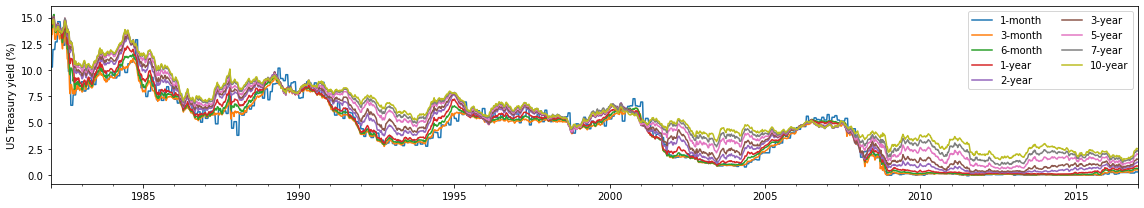

In [7]:
fig,ax = plt.subplots(1, figsize=(16, 3), sharex=True)
data_df = treas_df.iloc[:, 0:9]
data_df.plot(ax=ax)
plt.ylabel('US Treasury yield (%)')
plt.xlabel('')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

### Motivation
- To understand the dynamic relationships over time among the series
- To improve accuracy of forecasts for individual series by utilizing the additional information available from the related series in the forecasts for each series

### Foundations
##### Weak Stationarity of Multivariate Time Series

Consider a $N$-dimensional time series, $\mathbf{y}_t = \left[y_{1,t}, y_{2,t}, ..., y_{N,t}\right]^\prime$. This is said to be weakly stationary if the first two moments are finite and contant through time, that is,
1. $E\left[\mathbf{y}_t\right] = \boldsymbol{\mu}$
2. $E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_t-\boldsymbol{\mu})^\prime\right] \equiv \boldsymbol\Gamma_0 < \infty$ for all $t$
3. $E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_{t-h}-\boldsymbol{\mu})^\prime\right] \equiv \boldsymbol\Gamma_h$ for all $t$ and $h$

where the expectations are taken element-by-element over the joint distribution of $\mathbf{y}_t$:
- $\boldsymbol{\mu}$ is the vector of means $\boldsymbol\mu = \left[\mu_1, \mu_2, ..., \mu_N \right]$
- $\boldsymbol\Gamma_0$ is the $N\times N$ covariance matric where the $i$th diagonal element is the variance of $y_{i,t}$, and the $(i, j)$th element is the covariance between $y_{i,t}$ and ${y_{j,t}}$
- $\boldsymbol\Gamma_h$ is the cross-covariance matrix at lag $h$

#####  Obtaining Cross-Correlation Matrix from Cross-Covariance Matrix


**At lag 0**:

Let $\mathbf\Gamma_0$ be the covariance matrix at lag 0, $\mathbf D$ be a $N\times N$ diagonal matrix containing the standard deviations of $y_{i,t}$ for $i=1, ..., N$. The correlation matrix of $\mathbf{y}_t$ is defined as

$$\boldsymbol\rho_0 = \mathbf D^{-1}\mathbf\Gamma_0\mathbf D^{-1}$$

where the $(i, j)$th element of $\boldsymbol\rho_0$ is the correlation coefficient between $y_{i,t}$ and $y_{j,t}$ at time $t$:

$$\rho_{i,j}(0) = \dfrac{Cov\left[y_{i,t}, y_{j,t} \right]}{\sigma_{i,t} \sigma_{j,t}}$$

**At lag h**:

Let $\boldsymbol\Gamma_h = E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_{t-h}-\boldsymbol{\mu})^\prime\right]$ be the lag-$h$ covariance cross-covariance matrix of $\mathbf y_{t}$. The lag-$h$ cross-correlation matrix is defined as

$$\boldsymbol\rho_h = \mathbf D^{-1}\mathbf\Gamma_h\mathbf D^{-1}$$

The $(i,j)$th element of $\boldsymbol\rho_h$ is the correlation coefficient between $y_{i,t}$ and $y_{j,t-h}$:

$$\rho_{i,j}(h) = \dfrac{Cov\left[y_{i,t}, y_{j,t-h} \right]}{\sigma_{i,t} \sigma_{j,t}}$$


**What do we get from this?**

|Correlation Coefficient| Interpretation |
|:----|:----|
|$\rho_{i,j}(0)\neq0$|$y_{i,t}$ and $y_{j,t}$ are *contemporaneously linearly correlated*|
|$\rho_{i,j}(h)=\rho_{j,i}(h)=0$ for all $h\geq0$|$y_{i,t}$ and $y_{j,t}$ share *no linear relationship*|
|$\rho_{i,j}(h)=0$ and $\rho_{j,i}(h)=0$ for all $h>0$|$y_{i,t}$ and $y_{j,t}$ are said to be linearly *uncoupled*|
|$\rho_{i,j}(h)=0$ for all $h>0$, but $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *unidirectional (linear) relationship* between $y_{i,t}$ and $y_{j,t}$, where $y_{i,t}$ does not depend on $y_{j,t}$, but $y_{j,t}$ depends on (some) lagged values of $y_{i,t}$|
|$\rho_{i,j}(h)\neq0$ for at least some $h>0$ and $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *bi-directional (feedback) linear relationship* between $y_{i,t}$ and $y_{j,t}$|

For illustration, we consider the carbon monoxide and nitrous oxide time series from the Air Quality Dataset. 

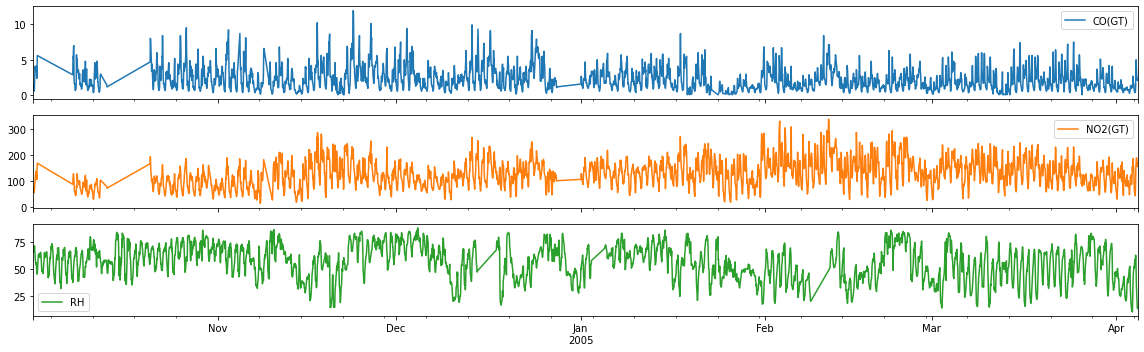

In [8]:
cols = ['CO(GT)', 'NO2(GT)', 'RH']
data_df = aq_df.loc[aq_df.index>'2004-10-01',cols]
fig,ax = plt.subplots(3, figsize=(16, 5), sharex=True)
data_df.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.tight_layout()
plt.show()

## Vector Autoregressive (VAR) Models 

- Generatization of the univariate AR model
- System regression model that treats all the variables as endogenous and allows each of them to depend on $p$ lagged values of itself and of all the other variables in the system

A VAR model of order $p$ can be represented as

$$\mathbf y_t=\mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf A_2 \mathbf y_{t-2} + ... + \mathbf A_p \mathbf y_{t-p} + \mathbf u_t = \mathbf a_0  + \sum_{j=1}^{p} \mathbf A_j \mathbf y_{t-j} + \mathbf u_t$$

where $\mathbf y_t$ is a $N\times 1$ vector containing $N$ endogenous variables, $\mathbf a_0$ is a $N\times 1$ vector of constants, $\mathbf A_1, \mathbf A_2, ..., \mathbf A_p$ are the $p$ $N\times N$ matrices of autoregressive coefficients, and $\mathbf u_t$ is a $N\times 1$ vector of white noise disturbances. 

### VAR(1) Model

#### Structural and Reduced Form

Consider the following bivariate system

$$ y_{1,t} = b_{1,0} - b_{1,2}y_{2,t} +  \varphi_{1,1}y_{1,t-1} + \varphi_{1,2}y_{2,t-1} + \varepsilon_{1,t}$$

$$ y_{2,t} = b_{2,0} - b_{2,1}y_{1,t} +  \varphi_{2,1}y_{1,t-1} + \varphi_{2,2}y_{2,t-1} + \varepsilon_{2,t}$$

where both $y_{1,t}$ and $y_{2,t}$ are assumed to be stationary, and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are the uncorrelated error terms with standard deviation $\sigma_{1,t}$ and $\sigma_{2,t}$, respectively. 

In matrix notation: 

\begin{equation*}
\begin{bmatrix}
1 & b_{1,2}\\
b_{1,2} & 1
\end{bmatrix} 
\begin{bmatrix}
y_{1,t} \\
y_{2,t}
\end{bmatrix} = 
\begin{bmatrix}
b_{1,0} \\
b_{2,0}
\end{bmatrix} + 
\begin{bmatrix}
\varphi_{1,1} & \varphi_{1,2}\\
\varphi_{2,1} & \varphi_{2,2}
\end{bmatrix} 
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1}
\end{bmatrix} +
\begin{bmatrix}
\varepsilon_{1,t} \\
\varepsilon_{2,t}
\end{bmatrix}
\end{equation*}

Let 
\begin{equation*}
\mathbf B \equiv \begin{bmatrix}
1 & b_{1,2}\\
b_{1,2} & 1
\end{bmatrix}, 
\mathbf y_{t} \equiv
\begin{bmatrix}
y_{1,t} \\
y_{2,t}
\end{bmatrix},
\mathbf Q_0 \equiv
\begin{bmatrix}
b_{1,0} \\
b_{2,0}
\end{bmatrix}, 
\mathbf Q_1 \equiv
\begin{bmatrix}
\varphi_{1,1} & \varphi_{1,2}\\
\varphi_{2,1} & \varphi_{2,2}
\end{bmatrix}, \end{equation*}
\begin{equation*}
\mathbf y_{t-1} \equiv
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1}
\end{bmatrix},
\boldsymbol \varepsilon_t \equiv
\begin{bmatrix}
\varepsilon_{1,t} \\
\varepsilon_{2,t}
\end{bmatrix}
\end{equation*}

then 

$$\mathbf B \mathbf y_t = \mathbf Q_0 + \mathbf Q_1 \mathbf y_{t-1} + \boldsymbol\varepsilon_t$$

> *Structural VAR (VAR in primitive form)*
- Described by equation above
- Captures contemporaneous feedback effects ($b_{1,2}, b_{2,1}$)
- Not very practical to use because standard estimation techniques require regressors to be uncorrelated with the error terms
- Contemporaneous terms cannot be used in forecasting
- Needs further manipulation to make it more useful (e.g. multiplying the matrix equation by $\mathbf B^{-1}$)

Multiplying the matrix equation by $\mathbf B^{-1}$), we get

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf u_t$$

or 

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 L\mathbf y_t + \mathbf u_t$$

where $\mathbf a_0 = \mathbf B^{-1}\mathbf Q_0$, $\mathbf A_1 = \mathbf B^{-1}\mathbf Q_1$, $L$ is the lag/backshift operator, and $\mathbf u_t = \mathbf B^{-1}\boldsymbol\varepsilon_t$, equivalently,

$$ y_{1,t} = a_{1,0} + a_{1,1}y_{1,t-1} + a_{1,2}y_{2,t-1} + u_{1,t}$$

$$ y_{2,t} = a_{2,0} + a_{2,1}y_{1,t-1} + a_{2,2}y_{2,t-1} + u_{2,t}$$

###### Reduced-form VAR (VAR in standard form)
- Described by equation above
- Only dependent on lagged endogenous variables (no contemporaneous feedback)
- Can be estimated using ordinary least squares (OLS)

#### VMA infinite representation and Stationarity

Consider the reduced form, standard VAR(1) model

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf u_t$$

Assuming that the process is weakly stationary and taking the expectation of $\mathbf y_t$, we have

$$E\left[\mathbf y_t\right] = \mathbf a_0 + \mathbf A_1 E\left[\mathbf y_{t-1}\right]$$

where $E\left[\mathbf u_t\right]=0.$ If we let $\tilde{\mathbf y}_{t}\equiv \mathbf y_t - \boldsymbol \mu$ be the mean-corrected time-series, we can write the model as

$$\tilde{\mathbf y}_{t} = \mathbf A_1 \tilde{\mathbf y}_{t-1} + \mathbf u_t$$

Substituting $\tilde{\mathbf y}_{t-1} = \mathbf A_1 \tilde{\mathbf y}_{t-2} + \mathbf u_{t-1}$, 

$$\tilde{\mathbf y}_{t} = \mathbf A_1 \left( \mathbf A_1 \tilde{\mathbf y}_{t-2} + \mathbf u_{t-1}\right)+ \mathbf u_t$$

If we keep iterating, we get

$$\mathbf y_{t} = \boldsymbol\mu + \sum_{i=1}^{\infty} \mathbf A_1^i  \mathbf u_{t-i} + \mathbf u_t$$

Letting $\boldsymbol\Theta_i\equiv A_1^i$, we get the **VMA infinite representation**


$$\mathbf y_{t} = \boldsymbol\mu + \sum_{i=1}^{\infty} \boldsymbol\Theta_i  \mathbf u_{t-i} + \mathbf u_t$$



###### Stationarity of the VAR(1) model
- All the N eigenvalues of the matrix $A_1$ must be less than 1 in modulus, to avoid that the coefficient matrix $A_1^j$ will either explode or converge to a nonzero matrix as $j$ goes to infinity.
- Provided that the covariance matrix of $u_t$ exists, the requirement that all the eigenvalues of $A_1$ are less than one in modulus is a necessary and sufficient condition for $y_t$ to be stable, and thus, stationary. 
- All roots of $det\left(\mathbf I_N - \mathbf A_1 z\right)=0$ must lie outside the unit circle. 

### VAR(p) Model

Consider the VAR(p) model described by 

$$\mathbf y_t=\mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf A_2 \mathbf y_{t-2} + ... + \mathbf A_p \mathbf y_{t-p} + \mathbf u_t = \mathbf a_0  + \sum_{j=1}^{p} \mathbf A_j \mathbf y_{t-j} + \mathbf u_t$$

Using the lag operator $L$, we get 

$$\tilde{\mathbf A} (L) \mathbf y_t = \mathbf a_0 + \mathbf u_t$$

where $\tilde{\mathbf A} (L) = (\mathbf I_N - A_1 L - ... - A_p L^p)$. Assuming that $\mathbf y_t$ is weakly stationary, we obtain that 

$$\boldsymbol\mu = E\left[\mathbf y_t\right] = (\mathbf I_N - A_1 L - ... - A_p L^p)^{-1} \mathbf a_0$$

Defining $\tilde{\mathbf y}_t=\mathbf y_t -\boldsymbol\mu$, we have

$$\tilde{\mathbf y}_t =  \mathbf A_1 \tilde{\mathbf y}_{t-1} + \mathbf A_2 \tilde{\mathbf y}_{t-2} + ... + \mathbf A_p \tilde{\mathbf y}_{t-p} + \mathbf u_t$$

###### Properties
- $Cov[\mathbf y_t, \mathbf u_t] = \Sigma_u$, the covariance matrix of $\mathbf u_t$
- $Cov[\mathbf y_{t-h}, \mathbf u_t] = \mathbf 0$ for any $h>0$
- $\boldsymbol\Gamma_h = \mathbf A_1 \boldsymbol\Gamma_{h-1} +...+\mathbf A_p \boldsymbol\Gamma_{h-p}$ for $h>0$
- $\boldsymbol\rho_h = \boldsymbol \Psi_1 \boldsymbol\Gamma_{h-1} +...+\boldsymbol \Psi_p \boldsymbol\Gamma_{h-p}$ for $h>0$, where $\boldsymbol \Psi_i = \mathbf D^{-1/2}\mathbf A_i D^{-1/2}$

######  Stationarity
- All roots of $det\left(\mathbf I_N - \mathbf A_1 z - ...-  \mathbf A_p z^p\right)=0$ must lie outside the unit circle.

### Specification of a VAR model: Choosing the order *p*

#### Using information criterion

To select the appropriate lag length, we minimize the multivariate version of the information criteria presented previously: 

*Akaike's (1973) information criterion*
$$(M)\operatorname{AIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + 2\dfrac{k}{T}$$

*Schwarz’s (1978) Bayesian information criterion's information criterion*
$$(M)\operatorname{BIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + \dfrac{k}{T}\operatorname{ln}(T)$$

*Hannan-Quinn’s (1979) information criterion*
$$(M)\operatorname{HQIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + \dfrac{k}{T}\operatorname{ln}(\operatorname{ln}(T))$$

where $M$ stands for multivariate, $\tilde{\boldsymbol\Sigma}_u$ is the estimated covariance matrix of the residuals, $T$ is the number of observations in the sample, and $k$ is the total number of equations in the VAR($p$) (i.e. $N^2p + N$ where $N$ is the number of equations and $p$ is the number of lags.

#### Additional criterion: 
*Final prediction error*

$$\operatorname{FPE}(p) = \left[\dfrac{T+Np+1}{T-Np+1} \right]^N |\tilde{\boldsymbol\Sigma}_u | $$



## Building a VAR model

### 1. Check stationarity

###### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
Recall: Null hypothesis is that an observable time series is stationary around a deterministic trend (i.e. trend-stationary). 

In [9]:
test_stat, p_val = [], []
cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
for c in data_df.columns: 
    kpss_res = kpss(data_df[c].dropna(), regression='ct')
    test_stat.append(kpss_res[0])
    p_val.append(kpss_res[1])
    cv_1pct.append(kpss_res[3]['1%'])
    cv_2p5pct.append(kpss_res[3]['1%'])
    cv_5pct.append(kpss_res[3]['5%'])
    cv_10pct.append(kpss_res[3]['10%'])
kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 2.5%': cv_2p5pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=data_df.columns).T
kpss_res_df.round(4)

,CO(GT),NO2(GT),RH
Test statistic,0.0702,0.3239,0.1149
p-value,0.1000,0.0100,0.1000
Critical value - 1%,0.2160,0.2160,0.2160
Critical value - 2.5%,0.2160,0.2160,0.2160
Critical value - 5%,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190


###### Augmented Dickey-Fuller test
Recall: Null hypothesis is that a unit root is present in a time series sample.

In [10]:
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in data_df.columns: 
    adf_res = adfuller(data_df[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=data_df.columns).T
adf_res_df.round(4)

,CO(GT),NO2(GT),RH
Test statistic,-7.0195,-6.7695,-6.8484
p-value,0.0000,0.0000,0.0000
Critical value - 1%,-3.4318,-3.4318,-3.4318
Critical value - 5%,-2.8622,-2.8622,-2.8622
Critical value - 10%,-2.5671,-2.5671,-2.5671


### 2. Split data into train and test sets

In [11]:
forecast_length = 24
train_df, test_df = data_df.iloc[:-forecast_length], data_df.iloc[-forecast_length:]
test_df = test_df.filter(test_df.columns[~test_df.columns.str.contains('-d')])

### 3. Select order *p*

We compute the different multivariate information criteria (AIC, BIC, HQIC), and FPE. We pick the set of order parameters that correspond to the lowest values. 

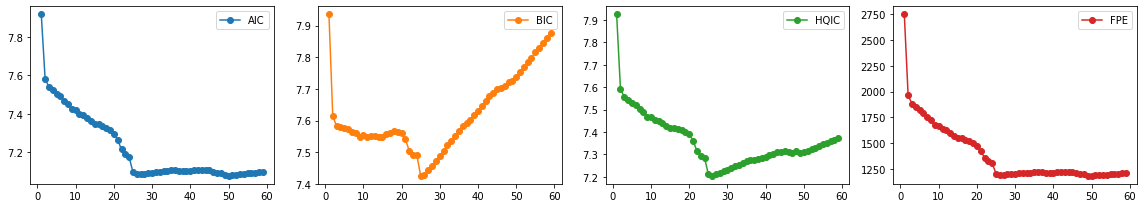

In [12]:
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_df.dropna())
p = np.arange(1,60)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(16, 3), sharex=True)
lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()

**Observation/s**: 
- We find BIC and HQIC to be lowest at $p=25$, and we also observe an elbow in the plots for AIC, and FPE, so we choose the number of lags to be 25. 

### 3. Fit VAR model with chosen order

In [13]:
var_model = model.fit(25)
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Nov, 2020
Time:                     14:59:37
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.42533
Nobs:                     4405.00    HQIC:                   7.21123
Log likelihood:          -34149.0    FPE:                    1205.40
AIC:                      7.09456    Det(Omega_mle):         1145.10
--------------------------------------------------------------------
Results for equation CO(GT)
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.225521         0.069726            3.234           0.001
L1.CO(GT)           0.976458         0.018952           51.523           0.000
L1.NO2(GT)          0.002284         0.000708            3.225     

### 4. Get forecast

In [14]:
forecast_var = pd.DataFrame(var_model.forecast(train_df.values, 
                                              steps=forecast_length), 
                           columns=train_df.columns, 
                           index=test_df.index)
forecast_var = forecast_var.rename(columns={c: c+'-VAR' for c in forecast_var.columns})

#### Comparison with ARIMA

In [15]:
%%time
select_model_params = {}
for c in cols: 
    select_model_params[c] = utils.fit_arima(train_df[c].values,
                                             p_list=np.arange(10),
                                             d_list=[0],
                                             q_list=np.arange(5))

CPU times: user 14h 57min 34s, sys: 1d 3h 24min 29s, total: 1d 18h 22min 4s
Wall time: 1h 39min 38s


In [16]:
selected_order = {}
for c in cols:
    min_order = (min(select_model_params[c].AIC.argmin(), 
                     select_model_params[c].BIC.argmin(), 
                     select_model_params[c].HQIC.argmin()))
    selected_order[c] = select_model_params[c].iloc[[min_order]].index
selected_order

{'CO(GT)': Index([(5, 0, 2)], dtype='object'),
 'NO2(GT)': Index([(4, 0, 2)], dtype='object'),
 'RH': Index([(3, 0, 3)], dtype='object')}

In [17]:
forecast_arima = {}
for c in cols:
    forecast_arima[c+'-ARIMA'] = utils.forecast_arima(train_df[c].values, 
                                                      test_df[c].values, 
                                                      order=selected_order[c][0])
forecast_arima = pd.DataFrame(forecast_arima, index=forecast_var.index)

In [18]:
forecasts = pd.concat([forecast_arima, forecast_var], axis=1)

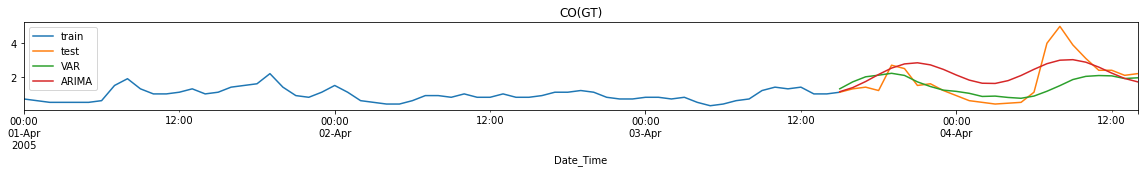

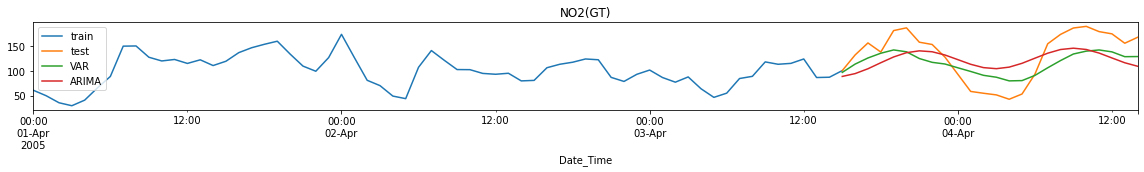

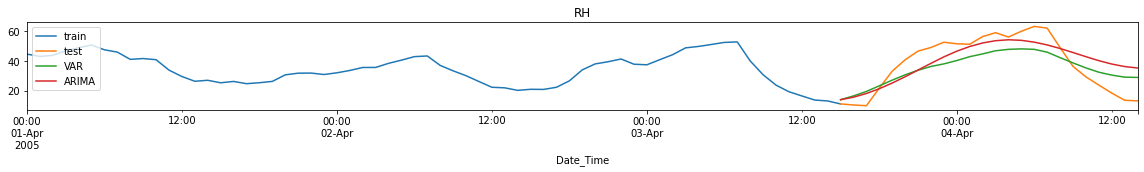

In [19]:
for c in cols:
    fig, ax = utils.plot_forecasts_static(train_df=train_df,
                                          test_df=test_df, 
                                          forecast_df=forecasts, 
                                          column_name=c,
                                          min_train_date='2005-04-01', 
                                          suffix=['-VAR', '-ARIMA'],
                                          title=c)


In [20]:
pd.concat([utils.test_performance_metrics(test_df, forecast_var, suffix='-VAR'),
           utils.test_performance_metrics(test_df, forecast_arima, suffix='-ARIMA')], axis=1)

,CO(GT)-VAR,NO2(GT)-VAR,RH-VAR,CO(GT)-ARIMA,NO2(GT)-ARIMA,RH-ARIMA
MAE,0.678041,31.711149,9.932015,0.831352,39.125067,9.131097
MSE,1.197003,1234.428682,116.545989,1.011001,1813.101286,122.476758
MAPE,39.039852,29.188694,35.612265,89.422325,41.119549,39.259104


## Structural Analysis

### Impulse Response Function (IRF)

- Coefficients of the VAR models are often difficult to interpret so practitioners often estimate the impulse response function. 
- IRFs trace out the time path of the effects of an exogenous shock to one (or more) of the endogenous variables on some or all of the other variables in a VAR system.
- IRF traces out the response of the dependent variable of the VAR system to shocks (also called innovations or impulses) in the error terms. 

###### IRF in the VAR system for Temperature and Humidity

Let $y_{1,t}$, $y_{2,t}$ and $y_{3,t}$ be the time series signals corresponding to CO signal, NO2 signal, and RH signal, respectively. Consider the moving average representation of the system shown below:

\begin{equation*}
\begin{bmatrix}
y_{1,t} \\
y_{2,t} \\
y_{3,t}
\end{bmatrix} = 
\begin{bmatrix}
\mu_{1} \\
\mu_{2} \\
\mu_{3}
\end{bmatrix} + 
\sum_{i=0}^\infty
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2} & \theta_{1,3}\\
\theta_{2,1} & \theta_{2,2} & \theta_{2,3}\\
\theta_{3,1} & \theta_{3,2} & \theta_{3,3}\\
\end{bmatrix} 
\begin{bmatrix}
u_{1,t-i} \\
u_{2,t-i} \\
u_{3,t-i}
\end{bmatrix}
\end{equation*}

Suppose $u_1$ in the first equation increases by a value of one standard deviation. 
- This shock will change $y_1$ in the current as well as the future periods.
- This shock will also have an impact on $y_2$. 

Suppose $u_2$ in the first equation increases by a value of one standard deviation. 
- This shock will change $y_2$ in the current as well as the future periods.
- This shock will also have an impact on $y_1$. 

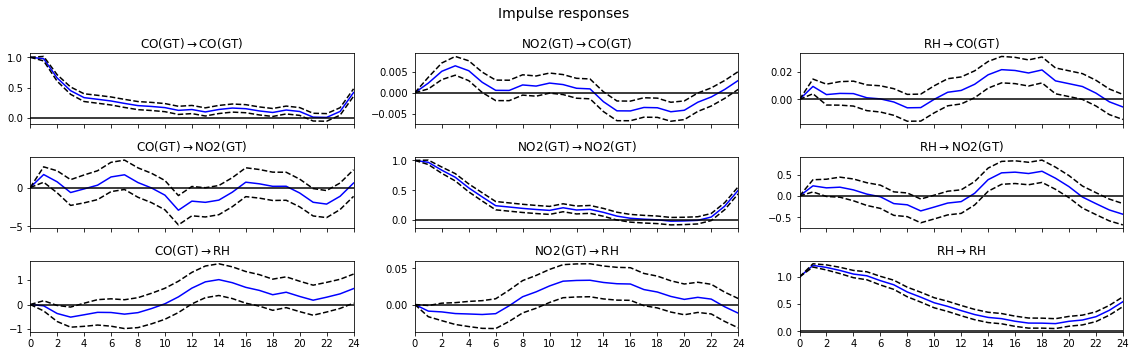

In [21]:
irf = var_model.irf(24)
ax = irf.plot(orth=False, figsize=(16, 5))
plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, 2))
plt.tight_layout()

### Forecast Error Variance Decomposition (FEVD)
- FEVD indicates the amount of information each variable contributes to the other variables in the autoregression
- It determines how much of the forecast error variance of each of the variables can be explained by exogenous shocks to the other variables.

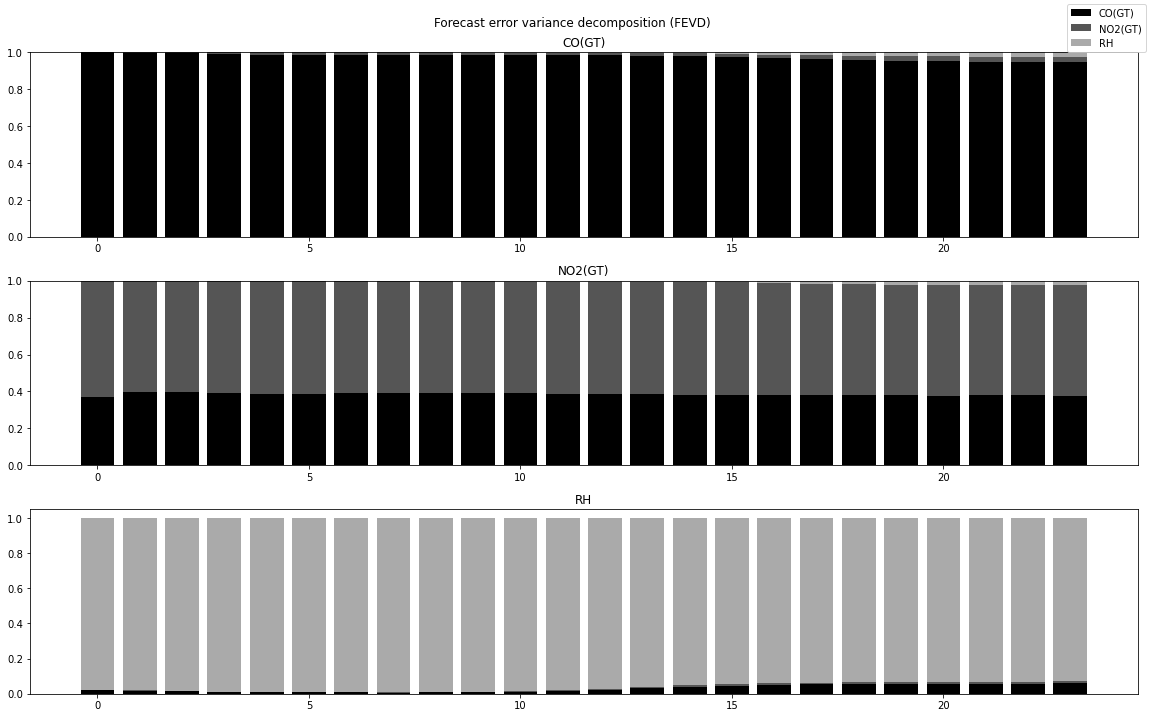

In [22]:
fevd = var_model.fevd(24)
ax = fevd.plot(figsize=(16, 10))
plt.tight_layout()